In [1]:
#Zmienić enkoder by analizował w dwóch kierunkach
#Dodać iteracyjne przewidywanie w dekoderze
#Używam średniej po ostatnich stanach w enkoderze zamiast ostatniego stanu
#Spróbować przeskalować wejscie
#Spróbować GRU

In [2]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import copy
#from tslearn.preprocessing import TimeSeriesResampler

In [3]:
with open("../Dane/Datasets/d50-resampled.pickle", "rb") as file:
    dataset=pickle.load(file)

#resampler=TimeSeriesResampler(256)

#dataset=torch.Tensor([resampler.transform(ar.reshape((1,-1,1))).reshape(-1,1) for ar in dataset])

In [4]:
#dataset=torch.rand(171988, 256, 1)

In [5]:
class DilatedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dilation, last_state_only=False, ifCuda=True):
        super().__init__()
        self.hidden_size=hidden_size
        self.dilation=dilation
        self.last_state_only=last_state_only
        self.ifCuda=ifCuda
        
        self.lstm=nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1,batch_first=True)
    
    def forward(self, X, H=None):
        assert X.shape[1]%self.dilation==0, "Wrong second dimension length"
        batchSize=X.shape[0]
        seqLength=X.shape[1]

        if self.last_state_only:
            L=[X[:,self.dilation-1::self.dilation,:]]
        else:
            L=[X[:,i::self.dilation,:] for i in range(self.dilation)]
        X=torch.cat(L,0)
        if H is None:
            out,(hid,_)=self.lstm(X)
        else:
            #assert H.shape[0]==0
            #H.reshape(H.shape[1:])
            H=torch.cat([H for i in range(self.dilation)],1)
            
            C=torch.zeros_like(H)
            out,(hid,_)=self.lstm(X,(H,C))
        if self.ifCuda:
            X=torch.zeros((batchSize, seqLength, self.hidden_size), device="cuda")
        else:
            X=torch.zeros((batchSize, seqLength, self.hidden_size))
        if self.last_state_only:
            X[:,self.dilation-1::self.dilation,:]=out
        else:
            for i in range(self.dilation):
                X[:,i::self.dilation,:]=out[i*batchSize:(i+1)*batchSize,:,:]
        
        return X, hid.reshape(hid.shape[1:])

In [6]:
class Enkoder(nn.Module):
    def __init__(self, ifCuda=True):
        super().__init__()
        self.L1=DilatedRNN(input_size=1, hidden_size=8, dilation=1, last_state_only=True, ifCuda=ifCuda)
        self.L2=DilatedRNN(input_size=8, hidden_size=8, dilation=4, last_state_only=True, ifCuda=ifCuda)
        self.L3=DilatedRNN(input_size=8, hidden_size=8, dilation=16, last_state_only=True, ifCuda=ifCuda)
        self.L4=DilatedRNN(input_size=8, hidden_size=8, dilation=64, last_state_only=True, ifCuda=ifCuda)
        
        self.prosta=nn.Sequential(
            nn.Linear(in_features=32, out_features=128),
            nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=32),
            nn.Softmax()
        )

    def forward(self, X):
        batchSize=X.shape[0]
        X,h1=self.L1(X)
        #h1=h1.reshape((X.shape[0],-1,h1.shape[-1]))
        X,h2=self.L2(X)
        #h2=h2.reshape((X.shape[0],-1,h2.shape[-1])).mean(dim=1)
        #h2=h2[-batchSize:,:]
        _,h3=self.L3(X)
        #h3=h3.reshape((X.shape[0],-1,h3.shape[-1])).mean(dim=1)
        #h3=h3[-batchSize:,:]
        _,h4=self.L4(X)
        #h4=h4.reshape((X.shape[0],-1,h4.shape[-1])).mean(dim=1)
        #h4=h4[-batchSize:,:]
        #print(h1.shape)
        #print(h2.shape)
        #print(h3.shape)
        return self.prosta(torch.cat((h1,h2,h3,h4),1))

In [7]:
class Dekoder(nn.Module):
    def __init__(self, hidden_size, ifCuda=True):
        super().__init__()
        self.ifCuda=ifCuda
        self.L4=DilatedRNN(input_size=32, hidden_size=16, dilation=1, ifCuda=ifCuda)
        self.L3=DilatedRNN(input_size=40, hidden_size=32, dilation=4, ifCuda=ifCuda)
        self.L2=DilatedRNN(input_size=hidden_size, hidden_size=40, dilation=16, ifCuda=ifCuda)
        self.L1=DilatedRNN(input_size=1, hidden_size=hidden_size, dilation=64, ifCuda=ifCuda)
        
        self.sequential1=nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=hidden_size*4),
            nn.Dropout(p=0.02),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size*4, out_features=hidden_size)           
        )
        
        self.sequential=nn.Sequential(
            nn.Linear(in_features=16, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )

    
    def forward(self, hid, generatedLength=256):
        hid=self.sequential1(hid)
        batchSize=hid.shape[0]
        hid=hid.reshape((1,*hid.shape))
        if self.ifCuda:
            zera=torch.zeros((batchSize, generatedLength,1),device="cuda")
        else:
            zera=torch.zeros((batchSize, generatedLength,1))
        
        out,_=self.L1(zera,hid)
        out,_=self.L2(out)
        out,_=self.L3(out)
        out,_=self.L4(out)
        out=self.sequential(out)
        
        #out=torch.empty((batchSize,generatedLength,1),device="cuda")
        #poprzednie=torch.zeros((batchSize,1,1), device="cuda")
        #for i in range(generatedLength):
        #    poprzednie,(hid,C)=self.lstm(poprzednie,(hid,C))
        #    poprzednie=self.linear2(self.linear1(poprzednie))
        #    out[:,i,:]=poprzednie.reshape((batchSize,1))
        return out

In [8]:
class DekoderProsty(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.lstm=nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=1,batch_first=True)
        self.sequential=nn.Sequential(
            nn.Linear(in_features=hidden_size, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=1)
        )
    
    def forward(self, hid, generatedLength=256):
        batchSize=hid.shape[0]
        hid=hid.reshape((1,*hid.shape))
        C=torch.zeros_like(hid)
        
        zera=torch.zeros((batchSize, generatedLength,1),device="cuda")
        out,_=self.lstm(zera,(hid,C))
        out=self.sequential(out)
        
        #out=torch.empty((batchSize,generatedLength,1),device="cuda")
        #poprzednie=torch.zeros((batchSize,1,1), device="cuda")
        #for i in range(generatedLength):
        #    poprzednie,(hid,C)=self.lstm(poprzednie,(hid,C))
        #    poprzednie=self.linear2(self.linear1(poprzednie))
        #    out[:,i,:]=poprzednie.reshape((batchSize,1))
        return out

In [9]:
class Klasyfikator(nn.Module):
    def __init__(self,input_size, d_size=512):
        super().__init__()
        self.sequential=nn.Sequential(
            nn.Linear(in_features=input_size, out_features=d_size),
            nn.ReLU(),
            nn.Linear(in_features=d_size, out_features=2)
        )
        
    def forward(self, X):
        #print(X.shape)
        return self.sequential(X)

In [10]:
class DTCR(nn.Module):
    """Choć póki co to dosyć szumna nazwa jak na aktualny stan implementacji."""
    def __init__(self, ifCuda=True):
        super().__init__()
        self.enkoder=Enkoder(ifCuda=ifCuda)
        self.dekoder=Dekoder(32, ifCuda=ifCuda)
        self.klasyfikator=Klasyfikator(32)
#        self.skala=nn.Parameter(torch.rand(1,32))
#        self.normalizujSkale()
    
#    def normalizujSkale(self):
#        with torch.no_grad():
#            self.skala/=torch.sum(self.skala)
    
#    def zakodujZeSkalowaniem(self, X):
#        hid=self.enkoder(X)
#        return hid/self.skala
    
    def forward(self, X):
        hid=self.enkoder(X)
        out=self.dekoder(hid, generatedLength=X.shape[1])
        labels=self.klasyfikator(hid)
        return out, labels

In [11]:
def generujFalszyweDane(dataset, alpha=0.2):
    """
    Wejscie [batch,seqLength, dimension]
    Zwraca tensor z wygenerowanymi fałszywymi próbkami, gdzie wyjście ma
    kształt [batch, seqLength*2, dimension] i wartości
    [:,:seqLength,:] odpowiadają danym prawdziwym, a [:,seqLength:,:] fałszywym.
    """
    seqLength=dataset.shape[1]
    out=torch.empty((dataset.shape[0], seqLength*2, *dataset.shape[2:]))
    #print(out.shape)
    out[:,:seqLength,:]=dataset
    out[:,seqLength:,:]=dataset
    for i in range(dataset.shape[0]):
        ind=np.random.choice(seqLength,int(seqLength*alpha),replace=False)
        ind2=ind.copy()+seqLength
        np.random.shuffle(ind2)
        #print(ind2,ind)
        out[i,ind2,:]=dataset[i,ind,:]
    return out

In [12]:
def zakodujDane(dataset, model, batch_size=256, ifCuda=True):
    data=torch.utils.data.DataLoader(dataset,batch_size=batch_size)
    if ifCuda:
        model=model.to("cuda")
        L=[model.enkoder(batch.to("cuda")) for batch in data]
    else:
        L=[model.enkoder(batch) for batch in data]
    return torch.cat(L,0)

In [13]:
def wyliczMacierzF(batch,model,k, ifCuda=True):
    #print(batch.shape)
    with torch.no_grad():
        zakodowane=zakodujDane(batch,model, ifCuda=ifCuda) # [N,m]
        W=torch.svd(zakodowane)
        F=W[0][:,:k] # [N,k]
    return F

def wyliczKMeansLoss(model, batch, F,lam=1, ifCuda=True, batch_size=256):
    #print(batch.shape)
    zakodowane=zakodujDane(batch,model, ifCuda=ifCuda, batch_size=batch_size)
    HTH=zakodowane@zakodowane.T # [N,N]
    score=torch.trace(HTH)
    score-=torch.trace(F.T@HTH@F)
    return score*lam

In [14]:
def uczModel(model, dataset, validationset, batch_size=128, ifCuda=True, lr=1e-3, epoch_count=30,
            log_every=50, update_F_every=100, k=10, lambdaKmeansDict={0:1}, lambdaRecoveryDict={0:1000}):
    kosztKlasyfikacji=nn.CrossEntropyLoss()
    kosztOdtwarzania=nn.MSELoss()
    seqLength=256
    def evalBatch(batch):
        klasyPrawdziwe=torch.ones(batch.shape[0],dtype=torch.long)
        klasyFalszywe=torch.zeros_like(klasyPrawdziwe)
        if ifCuda:
            batch=batch.to("cuda")
            klasyPrawdziwe=klasyPrawdziwe.to("cuda")
            klasyFalszywe=klasyFalszywe.to("cuda")
        klasy=torch.cat((klasyPrawdziwe, klasyFalszywe),0)
        #resultPrawdziwe=model(batch[:,:seqLength,:])
        resultPrawdziwe, labelsPrawdziwe=model(batch[:,:seqLength,:])
        resultFalszywe, labelsFalszywe=model(batch[:,seqLength:,:])
        scoreOdtwarzania=kosztOdtwarzania(resultPrawdziwe,batch[:,:seqLength,:])*lambdaRecovery

        #scoreKlasyfikacji=torch.Tensor([0]).reshape(()).to("cuda")
        scoreKlasyfikacji=kosztKlasyfikacji(torch.cat((labelsPrawdziwe,labelsFalszywe),0),klasy)
        
        #scoreKMeans=torch.Tensor([0]).reshape(()).to("cuda")
        scoreKMeans=wyliczKMeansLoss(model,batch[:,:seqLength,:],F, lam=lambdaKmeans, ifCuda=ifCuda)
        
        #print(scoreOdtwarzania,scoreKlasyfikacji,scoreKMeans)
        score=scoreOdtwarzania+scoreKlasyfikacji+scoreKMeans
        return score, (scoreOdtwarzania, scoreKlasyfikacji, scoreKMeans)
    
    if ifCuda:
        model=model.to("cuda")
    
    bestAvgValidationScore=np.inf
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    iter_counter=0
    historia=[]
    
    dataset=generujFalszyweDane(dataset)
    validationset=generujFalszyweDane(validationset)
    
    data_validation=torch.utils.data.DataLoader(validationset,batch_size=batch_size,drop_last=True)
    data_train=torch.utils.data.DataLoader(dataset,batch_size=batch_size, shuffle=True,drop_last=True)

    F=wyliczMacierzF(dataset[:batch_size,:seqLength,:],model,k, ifCuda)
    try:    
        for epoch in range(epoch_count):
            #Training
            if epoch in lambdaKmeansDict:
                lambdaKmeans=lambdaKmeansDict[epoch]
            if epoch in lambdaRecoveryDict:
                lambdaRecovery=lambdaRecoveryDict[epoch]    
                
            for batch in data_train:
                iter_counter+=1
                optimizer.zero_grad()
                score,scoreSzczegolowy=evalBatch(batch)
                score.backward()
                optimizer.step()
                #model.normalizujSkale()
                if iter_counter % log_every == 0:
                    print("Minibatch {0: >6}  | loss {1: >9.7f} | {2: >6.5f} {3: >6.5f} {4: >6.5f}".format(
                        iter_counter,score.item(), scoreSzczegolowy[0].item(),
                        scoreSzczegolowy[1].item(), scoreSzczegolowy[2].item()))
                if iter_counter % update_F_every==0:
                    F=wyliczMacierzF(batch[:,:seqLength,:],model,k, ifCuda)
            #Validation
            validationScore=0
            reconstructionScore=0
            clasificationScore=0
            kmeansScore=0
            with torch.no_grad():
                for batch in data_validation:
                    wyn=evalBatch(batch)
                    validationScore+=wyn[0]
                    reconstructionScore+=wyn[1][0]
                    clasificationScore+=wyn[1][1]
                    kmeansScore+=wyn[1][2]
            validationBatches=validationset.shape[0]/batch_size
            avgValidationScore=validationScore/validationBatches
            avgRecScore=reconstructionScore/validationBatches
            avgClasScore=clasificationScore/validationBatches
            avgKmeansScore=kmeansScore/validationBatches

            if avgValidationScore < bestAvgValidationScore:
                best_epoch = epoch
                bestAvgValidationScore=avgValidationScore
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            #print(avgClasScore)
            #print(avgKmeansScore)
            m = "Epoch {0: >2} | valid: {1: >6.5f} | best valid: {2: >6.5f} | best epoch {3: >2} | rec: {4: >6.5f} | clas: {5: >6.5f} | kmeans: {6: >6.5f}".format(
                epoch, avgValidationScore, bestAvgValidationScore, best_epoch, avgRecScore,avgClasScore,avgKmeansScore
            )
            historia.append((avgRecScore,avgClasScore,avgKmeansScore))
            print("{0}\n{1}\n{0}".format("-" * len(m), m))
            torch.save(model.state_dict(), "../Modele/DTCR-8-8-8-8-DilatedDekoder-d50({}epok)-{}-siecKombDekEnk-slabszaKlasyf-naprKmeans.pth".format(epoch,str(time.time())))
            print("Sleeping to cool GPU.")
            time.sleep(5)
    except KeyboardInterrupt:
        pass
#    if best_params is not None:
#        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
#        with torch.no_grad():
#            for param, best_param in zip(model.parameters(), best_params):
#                param[...] = best_param
    return historia

In [15]:
model=DTCR(ifCuda=True)

In [16]:
model.load_state_dict(torch.load("../Modele/kodowanie1-DTCR-8-8-8-8-naprKmeans-1624101630.9567149.pth"))

<All keys matched successfully>

In [17]:
podzial=165000
#trainset=dataset[:10000,:,:]
trainset=dataset[:podzial,:,:]
testset=dataset[podzial:,:,:]
testset=(testset-trainset.min())/(trainset.max()-trainset.min())
trainset=(trainset-trainset.min())/(trainset.max()-trainset.min())

In [18]:
W=uczModel(model, trainset,testset, batch_size=1024, 
           log_every=20, lr=0.005, epoch_count=100,update_F_every=50,
           ifCuda=True, k=7,
           lambdaKmeansDict={0:10},
           lambdaRecoveryDict={0:200})

----------------------------------------------------------------------------------------------------------------
Epoch 84 | valid: 0.49815 | best valid: 0.22155 | best epoch 25 | rec: 0.46508 | clas: 0.00065 | kmeans: 0.03242
----------------------------------------------------------------------------------------------------------------
Sleeping to cool GPU.
Minibatch  13700  | loss 0.5121582 | 0.40475 0.00033 0.10708
Minibatch  13720  | loss 0.4101568 | 0.36065 0.00144 0.04807
Minibatch  13740  | loss 0.3783270 | 0.34702 0.00190 0.02941
Minibatch  13760  | loss 0.3747463 | 0.35031 0.00014 0.02430
Minibatch  13780  | loss 0.3444266 | 0.32163 0.00243 0.02037
Minibatch  13800  | loss 0.3564223 | 0.33403 0.00042 0.02197
Minibatch  13820  | loss 0.3792752 | 0.35163 0.00018 0.02747
Minibatch  13840  | loss 0.3656139 | 0.34104 0.00016 0.02441


In [43]:
wyniki=np.concatenate([wyniki, np.array(W)])

In [19]:
wyniki=np.array(W).copy()

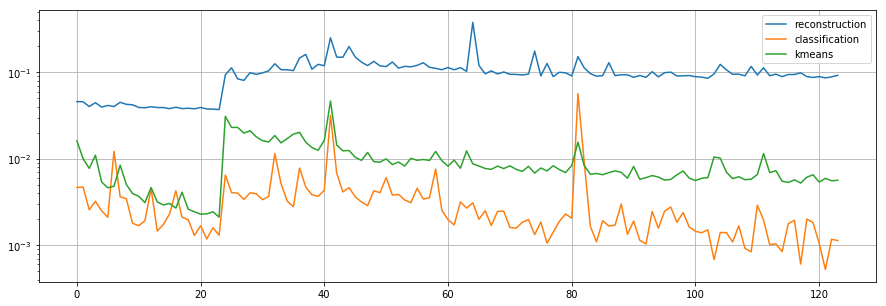

In [44]:
pocz=0
kon=200
plt.gcf().set_size_inches((15,5))
plt.grid(True)
plt.plot(wyniki[pocz:kon,0],label="reconstruction")
plt.plot(wyniki[pocz:kon,1],label="classification")
plt.plot(wyniki[pocz:kon,2], label="kmeans")

#plt.ylim(0.01,1)
plt.yscale("log")
plt.legend()

In [ ]:
#torch.save(model.state_dict(), "../Modele/DTCR-RCK-DilatedDekoder-d50(100epok)-8-8-8-8-{}.pth".format(str(time.time())))
#with open(f"../Modele/DTCR-OdtwarzanieIKlasyfikacja-DilatedDekoder-d10+d50(2x30epok)-{str(time.time())}.pickle","wb") as plik:
#    pickle.dump(model, plik)

# Analiza po doszkalaniu lambda=0.001

In [27]:
model.load_state_dict(torch.load("../Modele/DTCR-8-8-8-8-DilatedDekoder-d50(84epok)-1624114858.3464656-siecKombDekEnk-slabszaKlasyf-naprKmeans.pth"))

<All keys matched successfully>

In [28]:
model.to("cuda")
szereg=testset[:4,:,:].to("cuda")
X,_=model(szereg)

/home/i309016/.local/lib/python3.5/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


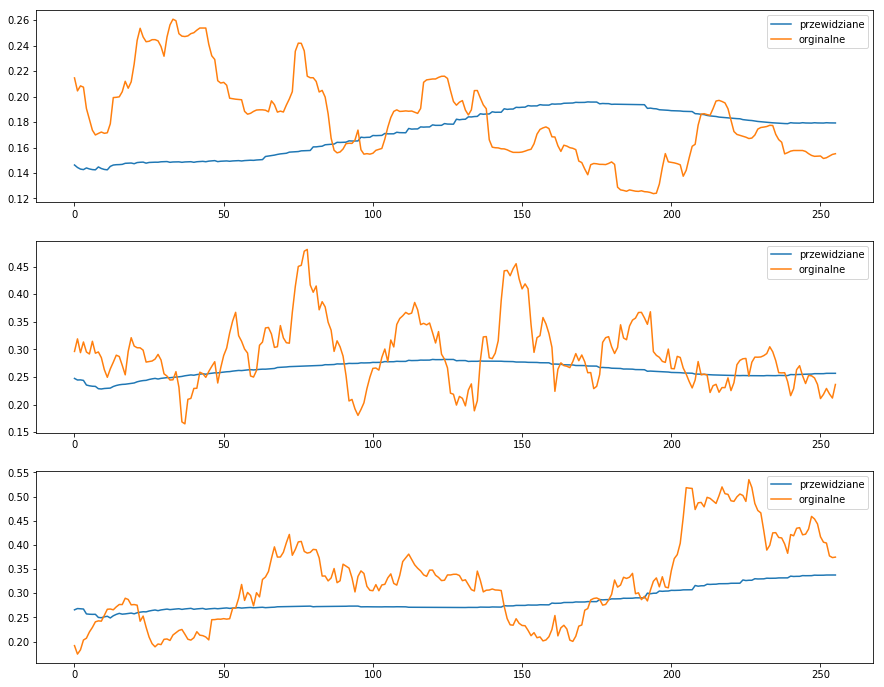

In [29]:
plt.gcf().set_size_inches((15,12))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(np.array(X[i,:,:].cpu().detach()), label="przewidziane")
    plt.plot(np.array(szereg[i,:,:].cpu()), label="orginalne")
    plt.legend()

In [30]:
with torch.no_grad():
    encoded_data=zakodujDane(testset, model, ifCuda=True).cpu().numpy()

In [31]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=7)
etyk=kmeans.fit_predict(encoded_data[:10000,:])

In [32]:
np.unique(etyk, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([1189,  793, 1098,  540, 1123,  955, 1290]))

In [33]:
tsne=TSNE(verbose=3, n_iter=1000)

encoded_data_tsne=tsne.fit_transform(encoded_data[:10000,:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6988 samples in 0.025s...
[t-SNE] Computed neighbors for 6988 samples in 0.534s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6988
[t-SNE] Computed conditional probabilities for sample 2000 / 6988
[t-SNE] Computed conditional probabilities for sample 3000 / 6988
[t-SNE] Computed conditional probabilities for sample 4000 / 6988
[t-SNE] Computed conditional probabilities for sample 5000 / 6988
[t-SNE] Computed conditional probabilities for sample 6000 / 6988
[t-SNE] Computed conditional probabilities for sample 6988 / 6988
[t-SNE] Mean sigma: 0.000215
[t-SNE] Computed conditional probabilities in 0.612s
[t-SNE] Iteration 50: error = 91.7683258, gradient norm = 0.0297148 (50 iterations in 0.862s)
[t-SNE] Iteration 100: error = 81.1354980, gradient norm = 0.0038445 (50 iterations in 0.776s)
[t-SNE] Iteration 150: error = 80.1266251, gradient norm = 0.0010988 (50 iterations in 0.759s)
[t-SNE] Iteration 200: error = 

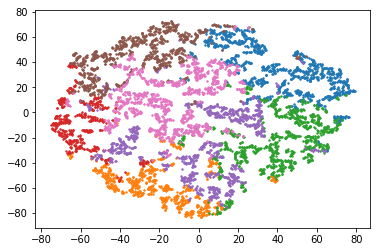

In [34]:
for j in range(7):
    plt.scatter(encoded_data_tsne[etyk==j,0],encoded_data_tsne[etyk==j,1],s=2)

In [52]:
T=[]
for i in [10,20,30,40,50,80,100,150]:
    tsne=TSNE(perplexity=i, n_iter=2000, n_jobs=-1)
    encoded_data_tsne=tsne.fit_transform(encoded_data[:10000,:])
    T.append(encoded_data_tsne)

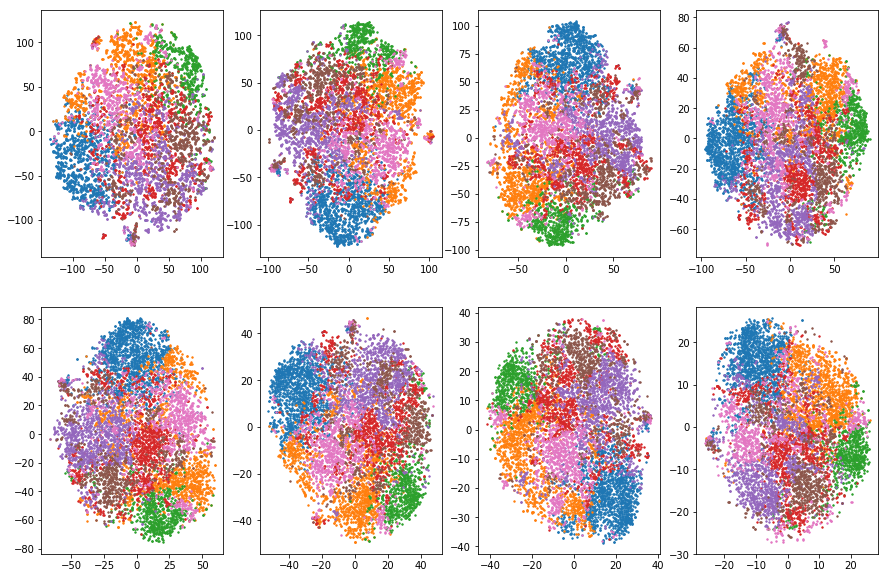

In [53]:
plt.gcf().set_size_inches((15,10))
for i in range(8):
    plt.subplot(2,4,i+1)
    for j in range(7):
        plt.scatter(T[i][etyk==j,0],T[i][etyk==j,1],s=2)

# Pełny z siecią kombinacyjną w enkoderze i dekoderze

In [ ]:
model.load_state_dict(torch.load("../Modele/DTCR-minimized-8-8-8-8-DilatedDekoder-RCK-d50(53epok)-kopiaZap-1623929961.7072186-siecKombDekEnk.pth"))

In [ ]:
model.to("cuda")
szereg=testset[:4,:,:].to("cuda")
X,_=model(szereg)

In [ ]:
plt.gcf().set_size_inches((15,12))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(np.array(X[i,:,:].cpu().detach()), label="przewidziane")
    plt.plot(np.array(szereg[i,:,:].cpu()), label="orginalne")
    plt.legend()

In [ ]:
encoded_data=zakodujDane(testset, model, ifCuda=True)

In [ ]:
from sklearn.cluster import KMeans

kmeans=KMeans(n_clusters=7)
etyk=kmeans.fit_predict(encoded_data[:10000,:])

In [ ]:
np.unique(etyk, return_counts=True)

In [ ]:
tsne=TSNE(verbose=3, n_iter=1000)

encoded_data_tsne=tsne.fit_transform(encoded_data[:10000,:])

In [ ]:
for j in range(7):
        plt.scatter(encoded_data_tsne[etyk==j,0],encoded_data_tsne[etyk==j,1],s=2)

In [ ]:
T=[]
for i in [10,20,30,40,50,80,100,150]:
    tsne=TSNE(perplexity=i, n_iter=1000)
    encoded_data_tsne=tsne.fit_transform(encoded_data[:10000,:])
    T.append(encoded_data_tsne)

In [ ]:
plt.gcf().set_size_inches((15,10))
for i in range(8):
    plt.subplot(2,4,i+1)
    for j in range(7):
        plt.scatter(T[i][etyk==j,0],T[i][etyk==j,1],s=2)